In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np # linear algebra
import pandas as pd 

### Step 1: Create A Data Loader - for train and test

In [3]:
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
# Step 1: Collect image paths and metadata into a DataFrame
def collect_image_paths(root_dir):
    data = []
    
    # Walk through each directory
    for class_folder in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_folder)
        print(class_path)
        if os.path.isdir(class_path):
            for split in ['Train', 'Test']:
                split_path = os.path.join(class_path, split)
                
                if os.path.isdir(split_path):
                    for image_name in os.listdir(split_path):
                        image_path = os.path.join(split_path, image_name)
                        data.append({
                            'path': image_path,
                            'target': class_folder,
                            'split': split
                        })
    
    return data


In [5]:
# Set the root directory of your dataset
root_dir = '/kaggle/input/bone-break-classification-image-dataset/Bone Break Classification/Bone Break Classification'

# Collect the data
data = collect_image_paths(root_dir)

# Create a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df.head())

/kaggle/input/bone-break-classification-image-dataset/Bone Break Classification/Bone Break Classification/Avulsion fracture
/kaggle/input/bone-break-classification-image-dataset/Bone Break Classification/Bone Break Classification/Spiral Fracture
/kaggle/input/bone-break-classification-image-dataset/Bone Break Classification/Bone Break Classification/Impacted fracture
/kaggle/input/bone-break-classification-image-dataset/Bone Break Classification/Bone Break Classification/Hairline Fracture
/kaggle/input/bone-break-classification-image-dataset/Bone Break Classification/Bone Break Classification/Greenstick fracture
/kaggle/input/bone-break-classification-image-dataset/Bone Break Classification/Bone Break Classification/Pathological fracture
/kaggle/input/bone-break-classification-image-dataset/Bone Break Classification/Bone Break Classification/Oblique fracture
/kaggle/input/bone-break-classification-image-dataset/Bone Break Classification/Bone Break Classification/Fracture Dislocation
/k

In [7]:
df.split.value_counts()

split
Train    989
Test     140
Name: count, dtype: int64

In [8]:
df.target.value_counts()

target
Fracture Dislocation     156
Comminuted fracture      148
Pathological fracture    134
Avulsion fracture        123
Greenstick fracture      122
Hairline Fracture        111
Spiral Fracture           86
Oblique fracture          85
Impacted fracture         84
Longitudinal fracture     80
Name: count, dtype: int64

In [11]:
# Create a Image Data generator for Keras TensorFlow CNN model

# Define parameters
batch_size = 10
img_height = 256  # Change as needed
img_width = 256   # Change as needed

# Data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
)

# Create data loaders
train_generator = datagen.flow_from_dataframe(
    dataframe=df[df['split'] == 'Train'],
    x_col='path',
    y_col='target',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'  # For multi-class classification
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=df[df['split'] == 'Test'],
    x_col='path',
    y_col='target',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'  # For multi-class classification
)

Found 989 validated image filenames belonging to 10 classes.
Found 140 validated image filenames belonging to 10 classes.


In [12]:
# Verify the data loaders
print(f'Train samples: {train_generator.samples}')
print(f'Validation samples: {validation_generator.samples}')

Train samples: 989
Validation samples: 140


### Step 2: Load and Visualise some randome images (10). With title as respective class and also pixel ranges

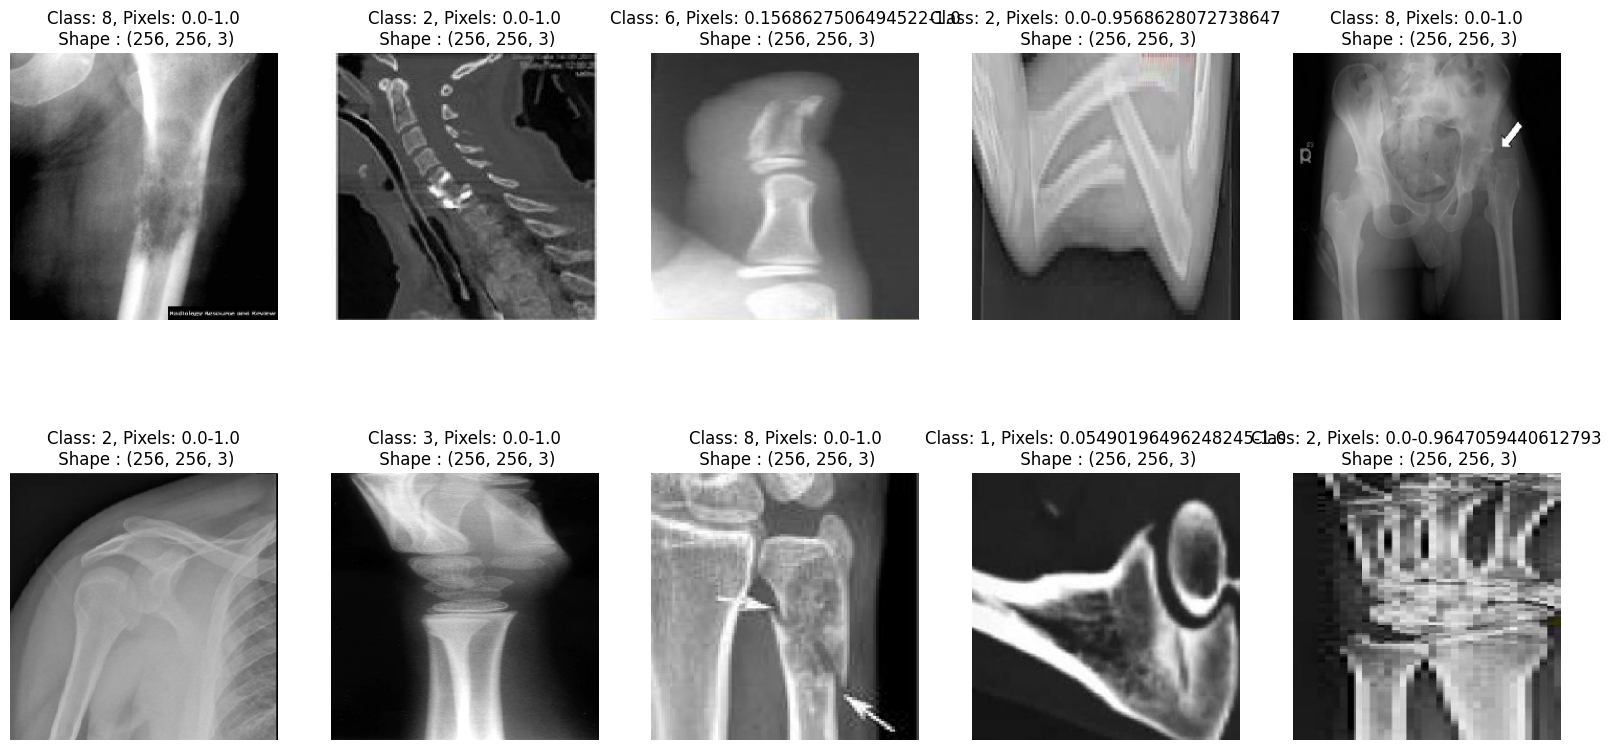

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot images
def plot_images(generator, num_images=10):
    images, labels = next(generator)
    plt.figure(figsize=(20, 10))
    
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f"Class: {np.argmax(labels[i])}, Pixels: {images[i].min()}-{images[i].max()}\n Shape : {images[i].shape}")
        plt.axis('off')
    
    plt.show()

# Plot random images from the training data
plot_images(train_generator, num_images=10)

### Step 3: Pre-Process Images - ( Normalization if required can add this in first layer operation)
- it's handled by the rescale=1./255 parameter in the ImageDataGenerator. If further preprocessing is needed, you can add layers directly to your CNN architecture.

### Step 4: Create CNN Architecture

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

# Define a simple CNN model
model = Sequential([
    Input(shape=(256, 256, 3)),  # Explicitly define the input shape here
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
    ])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

I0000 00:00:1756104117.206268      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756104117.207059      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [17]:
# Display the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,840,266 (56.61 MB)

 Trainable params: 14,840,266 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

### Step 5: Start Training and Show training graph

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1756104173.644774     116 service.cc:148] XLA service 0x7bd53c0050a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756104173.646356     116 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1756104173.646377     116 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1756104174.051543     116 cuda_dnn.cc:529] Loaded cuDNN version 90300


 4/99 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.0667 - loss: 4.0510

I0000 00:00:1756104178.747968     116 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


99/99 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.1149 - loss: 2.6486 - val_accuracy: 0.1357 - val_loss: 2.2922
Epoch 2/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.1303 - loss: 2.2773 - val_accuracy: 0.1571 - val_loss: 2.2705
Epoch 3/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.2429 - loss: 2.1766 - val_accuracy: 0.1786 - val_loss: 2.3182
Epoch 4/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.2992 - loss: 1.9424 - val_accuracy: 0.1929 - val_loss: 2.3130
Epoch 5/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.4289 - loss: 1.6984 - val_accuracy: 0.2786 - val_loss: 2.4276


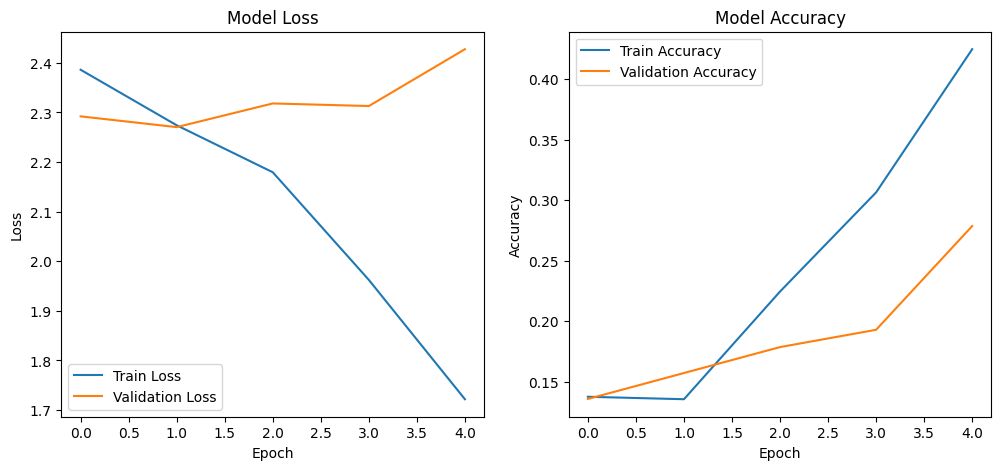

In [18]:
import matplotlib.pyplot as plt

# Ensure generators are reset before training
validation_generator.reset()
train_generator.reset()

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    verbose=1
)

# Plot training & validation loss values
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Trying a smaller Architecture

In [19]:
from tensorflow.keras.optimizers import Adam

# Define a simple CNN model
model2 = Sequential([
    Input(shape=(256, 256, 3)),  # Explicitly define the input shape here
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(40, activation='relu'),
    Dense(10, activation='softmax')  # 10 classes
])

# Compile the model
model2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 492032)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 40)             │    19,681,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           410 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,757,378 (75.37 MB)

 Trainable params: 19,757,378 (75.37 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - accuracy: 0.1450 - loss: 3.2215 - val_accuracy: 0.1000 - val_loss: 2.3072
Epoch 2/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.1733 - loss: 2.2630 - val_accuracy: 0.2357 - val_loss: 2.2765
Epoch 3/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.3520 - loss: 1.9344 - val_accuracy: 0.2214 - val_loss: 2.3362
Epoch 4/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.6354 - loss: 1.2049 - val_accuracy: 0.2286 - val_loss: 3.2666
Epoch 5/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.8496 - loss: 0.5864 - val_accuracy: 0.2643 - val_loss: 3.6253


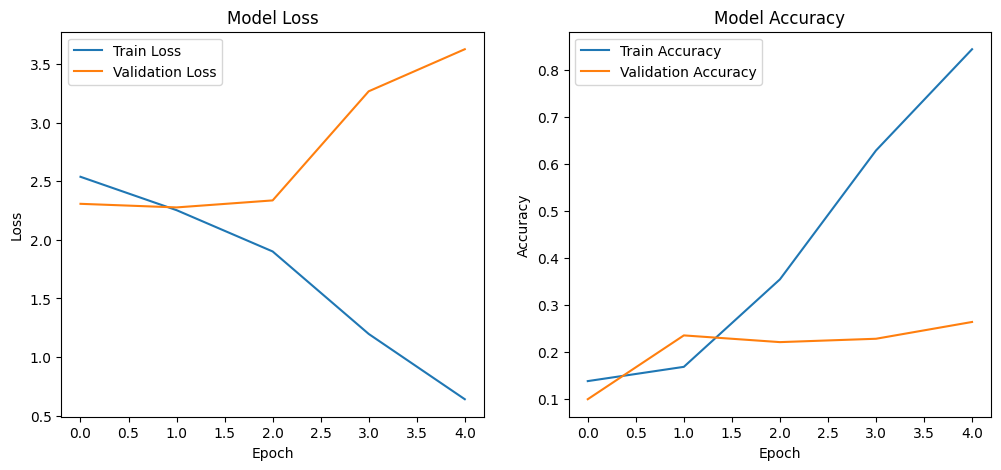

In [20]:
import matplotlib.pyplot as plt

# Ensure generators are reset before training
validation_generator.reset()
train_generator.reset()

# Train the model
history = model2.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    verbose=1
)

# Plot training & validation loss values
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Step 6: Prediction Results

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Accuracy: 0.10


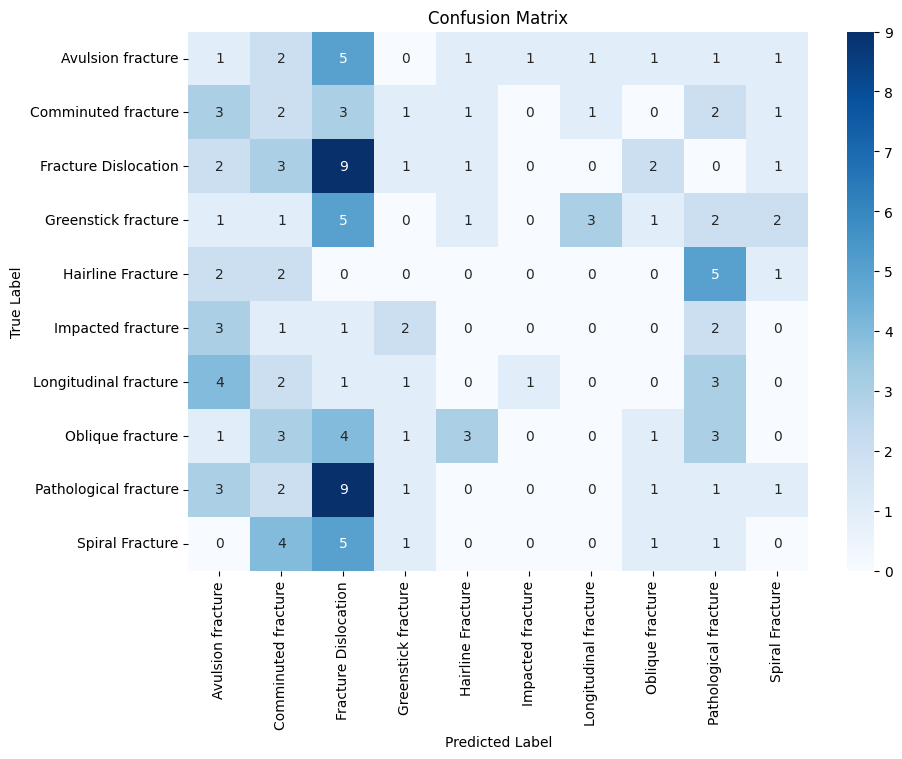

In [21]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Make predictions on the validation set
validation_generator.reset()
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_labels = validation_generator.classes

# Compute accuracy
accuracy = accuracy_score(true_labels, predicted_classes)
print(f'Accuracy: {accuracy:.2f}')

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


## Task - 2 : Applying Transfer Learning with Data Augmentation

Implementation Steps

- **Data Augmentation**: Increase dataset diversity using random transformations.
- **Model Checkpoints**: Save the best model based on validation performance.
- **Early Stopping**: Stop training when the model's performance stops improving